In [ ]:
# Import Libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Maybe don't need
from sklearn.model_selection import train_test_split


In [ ]:
# Other imports
!pip install meteostat
from datetime import datetime
from meteostat import Hourly
from meteostat import Point
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn import datasets
from sklearn import metrics

In [ ]:
# Testing Variables
numStations = 1    # Change num to len(fips) for full test

In [ ]:
# Set time period for data imports
startTime = datetime(2018, 1, 1)
endTime = datetime(2018, 12, 31, 23, 59)

startTime = pd.to_datetime(startTime)
endTime = pd.to_datetime(endTime)
timeSeries = pd.date_range(start=startTime, end=endTime, freq='15min')

In [ ]:
# Pull data for centroid of US counties
tempData = pd.read_excel("us-county-boundaries.xlsx")
countyData = tempData[['GEOID', 'Geo Point']]
countyData.sort_values(by = ['GEOID'], inplace=True)
countyData[['lat', 'long']] = countyData['Geo Point'].str.split(',', expand=True)
countyData.drop(columns=['Geo Point'], inplace=True)
print(countyData.head(10))

      GEOID            lat             long
1433   1001  32.5349201866    -86.642749235
1215   1003  30.6609696648   -87.7498400784
1457   1005  31.8696032448   -85.3931969755
1046   1007  32.9986442965   -87.1264391014
2591   1009  33.9808673856   -86.5673709608
1792   1011  32.1005542205   -85.7156972254
1528   1013  31.7524339429   -86.6802892154
3200   1015  33.7714324565   -85.8260308543
948    1017  32.9143722298   -85.3920429513
1519   1019  34.1759559677   -85.6037937156


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Fetch weather data in US in time range
weatherData = pd.DataFrame()
for i in range(numStations):
  row = countyData.iloc[i]
  latTemp = float(row['lat'])
  longTemp = float(row['long'])
  tempPoint = Point(latTemp, longTemp)
  temp = Hourly(tempPoint, startTime, endTime)
  dataTemp = temp.fetch()
  if(not dataTemp.empty):
    dataTemp.drop('dwpt', axis=1, inplace=True)
    dataTemp.drop('snow', axis=1, inplace=True)
    dataTemp.drop('wpgt', axis=1, inplace=True)
    dataTemp.drop('tsun', axis=1, inplace=True)
    dataTemp.drop('coco', axis=1, inplace=True)

    # Rename Data to unique identifiers
    dataTemp.rename(columns={'temp': str(row['GEOID']) + 'temp'}, inplace=True)
    dataTemp.rename(columns={'rhum': str(row['GEOID']) + 'rhum'}, inplace=True)
    dataTemp.rename(columns={'prcp': str(row['GEOID']) + 'prcp'}, inplace=True)
    dataTemp.rename(columns={'wdir': str(row['GEOID']) + 'wdir'}, inplace=True)
    dataTemp.rename(columns={'wspd': str(row['GEOID']) + 'wspd'}, inplace=True)
    dataTemp.rename(columns={'pres': str(row['GEOID']) + 'pres'}, inplace=True)

    # Begin Joining Data w/ unique column names
    if weatherData.empty:
      weatherData = dataTemp
      print('reset the Dataframe')
    else:
      weatherData = pd.concat([weatherData, dataTemp], axis=1)
      print('concat with dataframe')
  else:
    print('Empty dataTemp')
  # Add delay in fetching data to prevent query errors. Experimentation required for reasonable amount of sleep
  time.sleep(.25)

# Print DataFrame
print(weatherData)

# Clean Data
weatherData15min = weatherData.resample('15min').mean()
weatherData15min = weatherData15min.interpolate()
weatherData15min = weatherData15min.bfill()
weatherData15min = weatherData15min.dropna(axis=1)

# Ensure index matches neccesary format. Including last 45 minutes
weatherData15min = weatherData15min.reindex(timeSeries)
weatherData15min = weatherData15min.ffill()
weatherData15min = weatherData15min.bfill()

reset the Dataframe
                     1001temp  1001rhum  1001prcp  1001wdir  1001wspd  \
time                                                                    
2018-01-01 01:00:00       2.5      59.0       NaN     350.0      20.5   
2018-01-01 02:00:00       1.6      55.0       NaN     360.0      20.5   
2018-01-01 03:00:00       0.3      57.0       NaN     350.0      16.6   
2018-01-01 04:00:00      -0.7      60.0       NaN     350.0      16.6   
2018-01-01 05:00:00      -1.0      54.0       NaN     350.0      24.1   
...                       ...       ...       ...       ...       ...   
2018-12-31 19:00:00      23.4      77.0       NaN     180.0      14.8   
2018-12-31 20:00:00      24.0      75.0       NaN     170.0      20.5   
2018-12-31 21:00:00      24.0      75.0       NaN     180.0      25.9   
2018-12-31 22:00:00      23.6      77.0       NaN     180.0      20.5   
2018-12-31 23:00:00      22.6      83.0       NaN     180.0      20.5   

                     1001pres 

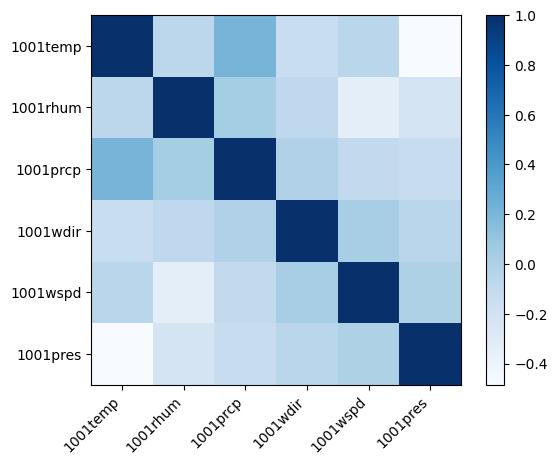

          1001temp  1001rhum  1001prcp  1001wdir  1001wspd  1001pres
1001temp  1.000000 -0.069080  0.215490 -0.140148 -0.056120 -0.484927
1001rhum -0.069080  1.000000  0.038333 -0.084848 -0.335770 -0.224744
1001prcp  0.215490  0.038333  1.000000 -0.012945 -0.101304 -0.129115
1001wdir -0.140148 -0.084848 -0.012945  1.000000  0.026057 -0.059011
1001wspd -0.056120 -0.335770 -0.101304  0.026057  1.000000 -0.004862
1001pres -0.484927 -0.224744 -0.129115 -0.059011 -0.004862  1.000000
          1001temp  1001rhum  1001prcp  1001wdir  1001wspd  1001pres
1001temp      True     False     False     False     False     False
1001rhum     False      True     False     False     False     False
1001prcp     False     False      True     False     False     False
1001wdir     False     False     False      True     False     False
1001wspd     False     False     False     False      True     False
1001pres     False     False     False     False     False      True


In [ ]:
# Determining Redundant Input Features Using Correlation Matrix
matrix = weatherData15min.corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

# Continue to Explore Correlation Matrix
print(matrix)
print(matrix>0.7)

In [ ]:
# Standardize the Weather Data set
scaler = StandardScaler()
weatherData15min = scaler.fit_transform(weatherData15min)

In [ ]:
# Pull Outage Data into Program
tempData = pd.read_csv("eaglei_outages_2018.csv")
outageData = tempData[['run_start_time', 'fips_code']]

In [ ]:
# Fetching Outage Data
for i in range(numStations):
  # Get Data
  curFips = countyData.iloc[i]['GEOID']
  temp = outageData.loc[outageData['fips_code'].isin([curFips])]

  # Adjust Data to have run_start_time as index, and values as 1 or 0 based on outage.
  temp['run_start_time'] = pd.to_datetime(temp['run_start_time'], format='%Y-%m-%d %H:%M:%S')
  temp.set_index('run_start_time', inplace=True)
  temp.loc[temp['fips_code'] == curFips, 'fips_code'] = 1
  temp.rename(columns={'fips_code': str(curFips)}, inplace=True)

  # Concatenate data onto Outage Data 2 set
  if i == 0:
    outageData2 = pd.DataFrame(temp, index = timeSeries)
  else:
    outageData2 = outageData2.join(temp)

# Fill NaN with 0, to be readable by ML model
outageData2 = outageData2.fillna(0)

# Explore the Output
print(outageData2.head())
print(outageData2.shape)
outageData2.describe()

                     1001
2018-01-01 00:00:00   0.0
2018-01-01 00:15:00   0.0
2018-01-01 00:30:00   0.0
2018-01-01 00:45:00   0.0
2018-01-01 01:00:00   1.0
(35040, 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,1001
count,35040.000000
mean,0.024144
std,0.153498
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
# Create training and testing sets
x_train = weatherData15min
y_train = outageData2
inputShape = x_train.shape[1]
outputShape = y_train.shape[1]

# Reshape the input data to have correct shape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train.shape)

# Compute Class Weights
class_weights = {}
count = {0: 0, 1: 0}
for col in y_train.columns:
  tempCount = y_train[col].value_counts()
  count[0] += tempCount.get(0,0)
  count[1] += tempCount.get(1,0)
print(count)
if(count[0] > count[1]):
  class_weights[0] = count[0] / count[0]
  class_weights[1] = count[0] / count[1]
else:
  class_weights[0] = count[1] / count[0]
  class_weights[1] = count[1] / count[1]
print(class_weights)

# Convert y data into array
y_train = y_train.to_numpy()

(35040, 6, 1)
{0: 34194, 1: 846}
{0: 1.0, 1: 40.41843971631206}


In [ ]:
# Define Model
model = tf.keras.models.Sequential()

# Add Layers. Consider Adding Pooling/Figure how to add them
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(inputShape,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=outputShape, activation='sigmoid'))

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=10, min_lr=1e-6)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/tmp/ckpt/checkpoint.model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 6, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,177 (539.75 KB)

 Trainable params: 137,985 (539.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Train the model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_split = 0.2,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint],
                    class_weight = class_weights,
#                    shuffle=False,
                    verbose=0)

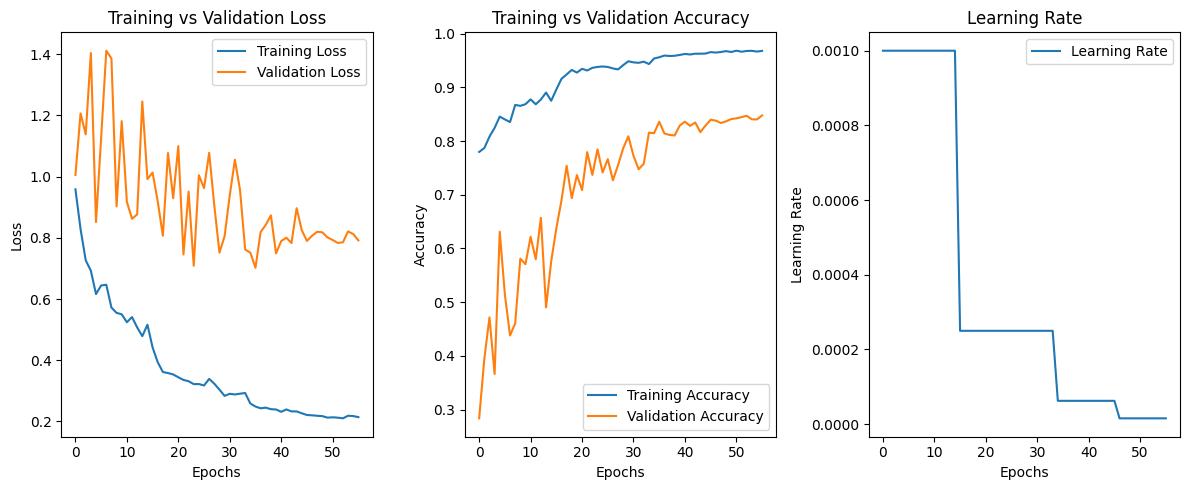

In [ ]:
# Visualize Data
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# verifying model on Another Dataset
# Fetching Outage Data
i = 2;
curFips = countyData.iloc[i]['GEOID']
temp = outageData.loc[outageData['fips_code'].isin([curFips])]

# Adjust Data to have run_start_time as index, and values as 1 or 0 based on outage.
temp['run_start_time'] = pd.to_datetime(temp['run_start_time'], format='%Y-%m-%d %H:%M:%S')
temp.set_index('run_start_time', inplace=True)
temp.loc[temp['fips_code'] == curFips, 'fips_code'] = 1
temp.rename(columns={'fips_code': str(curFips)}, inplace=True)

# Ensure data has correct number of columns
outageTestData = pd.DataFrame(temp, index = timeSeries)

# Fill NaN with 0, to be readable by ML model
outageTestData = outageTestData.fillna(0)

# Compute Class Weights
testWeights = {}
count = {0: 0, 1: 0}
for col in outageTestData.columns:
  tempCount = outageTestData[col].value_counts()
  count[0] += tempCount.get(0,0)
  count[1] += tempCount.get(1,0)
print(count)
testWeights[0] = count[0] / (count[0] + count[1])
testWeights[1] = count[1] / (count[1] + count[0])

print(class_weights)

# Explore the Output
print(outageTestData.sum())

{0: 34293, 1: 747}
{0: 1.0, 1: 40.41843971631206}
1005    747.0
dtype: float64


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Fetch weather data in US in time range
weatherTestData = pd.DataFrame()
row = countyData.iloc[i]
latTemp = float(row['lat'])
longTemp = float(row['long'])
tempPoint = Point(latTemp, longTemp)
temp = Hourly(tempPoint, startTime, endTime)
dataTemp = temp.fetch()
if(not dataTemp.empty):
  dataTemp.drop('dwpt', axis=1, inplace=True)
  dataTemp.drop('snow', axis=1, inplace=True)
  dataTemp.drop('wpgt', axis=1, inplace=True)
  dataTemp.drop('tsun', axis=1, inplace=True)
  dataTemp.drop('coco', axis=1, inplace=True)

  # Rename Data to unique identifiers
  dataTemp.rename(columns={'temp': str(row['GEOID']) + 'temp'}, inplace=True)
  dataTemp.rename(columns={'rhum': str(row['GEOID']) + 'rhum'}, inplace=True)
  dataTemp.rename(columns={'prcp': str(row['GEOID']) + 'prcp'}, inplace=True)
  dataTemp.rename(columns={'wdir': str(row['GEOID']) + 'wdir'}, inplace=True)
  dataTemp.rename(columns={'wspd': str(row['GEOID']) + 'wspd'}, inplace=True)
  dataTemp.rename(columns={'pres': str(row['GEOID']) + 'pres'}, inplace=True)

  # Begin Joining Data w/ unique column names
  weatherTestData = dataTemp

# Add delay in fetching data to prevent query errors. Experimentation required for reasonable amount of sleep
time.sleep(.25)

# Clean Data
weatherTestData15min = weatherTestData.resample('15min').mean()
weatherTestData15min = weatherTestData15min.interpolate()
weatherTestData15min = weatherTestData15min.bfill()
weatherTestData15min = weatherTestData15min.dropna(axis=1)

# Ensure index matches neccesary format. Including last 45 minutes
weatherTestData15min = weatherTestData15min.reindex(timeSeries)
weatherTestData15min = weatherTestData15min.ffill()
weatherTestData15min = weatherTestData15min.bfill()

In [ ]:
# Standardize the Weather Data set
testScaler = StandardScaler()
weatherTestData15min = testScaler.fit_transform(weatherTestData15min)

# Create training and testing sets
x_test = weatherTestData15min
y_test = outageTestData.to_numpy()

# Reshape the input data to have correct shape for CNN
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
eval = model.evaluate(x_test, y_test)
print(eval)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8797 - loss: 0.6468
[0.3953089118003845, 0.928681492805481]
